# Double-slit model
## AMCDawes
A model of the interference between a plane-wave LO and the far-field double-slit output. The FFT is computed to model what we expect to measure in our experimental setup. Physically accurate parameters have been chosen.

Comments:
 - The three-peak Fourier output is fairly consistent over a wide range of parameters
 - LO is a plane-wave at first, then a Gaussian beam later on in the notebook.
 - LO is at an angle, signal is normal-incident. This is not the same as
the experiment, but easier to treat numerically. TODO: swap these around

In [1]:
import matplotlib.pyplot as plt
from numpy import pi, sin, cos, linspace, exp, real, imag, abs, conj, meshgrid, log, log10, angle
from numpy.fft import fft, fftshift, ifft
from mpl_toolkits.mplot3d import axes3d

import BeamOptics as bopt

In [2]:
%matplotlib inline

In [3]:
b=.08*1e-3  # the slit width
a=.5*1e-3  # the slit spacing
k=2*pi/(795*1e-9)  # longitudinal wavenumber
wt=0  # let time be zero
C=1  # unit amplitude
L=1.8  # distance from slits to CCD
d=.016  # distance from signal to LO at upstream end (used to calculate k_perp)
ccdwidth = 1300  # number of pixels
pixwidth = 20e-6  # pixel width (in meters)

y = linspace(-pixwidth*ccdwidth/2,pixwidth*ccdwidth/2,ccdwidth)

In [4]:
def alpha(y,a):
    return k*a*y/(2*L)

In [5]:
def beta(y,b):
    return k*b*y/(2*L)

In [6]:
def E_ds(y,a,b):
    """ Double-slit field """
    # From Hecht p 458:
    #return b*C*(sin(beta(y)) / beta(y)) * (sin(wt-k*L) + sin(wt-k*L+2*alpha(y)))
    # drop the time-dep term as it will average away:
    return 2*b*C*(sin(beta(y,b)) / beta(y,b)) * cos(alpha(y,a)) #* sin(wt - k*L + alpha(y))

In [7]:
def E_dg(y,a,b):
    """ Double gaussian field """
    # The width needs to be small enough to see interference
    # otherwise the beam doesn't diffract and shows no interference.
    # We're using b for the gaussian width (i.e. equal to the slit width)
    w=b
    #return C*exp(1j*k*0.1*d*y/L)
    return bopt.gaussian_beam(0,y-a/2,L,E0=1,wavelambda=795e-9,w0=w,k=[0,0,k]) + bopt.gaussian_beam(0,y+a/2,L,E0=1,wavelambda=795e-9,w0=w,k=[0,0,k])

In [8]:
def E_lo(y,d):
    """Plane-wave LO beam"""
    return C*exp(1j*k*d*y/L)

### Sanity check: plot the field:

Text(0.5,1,'Double slit field')

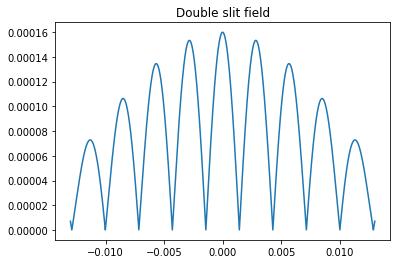

In [9]:
plt.plot(y,abs(E_ds(y,a,b)))
plt.title("Double slit field")

Text(0.5,1,'Double-Gaussian field')

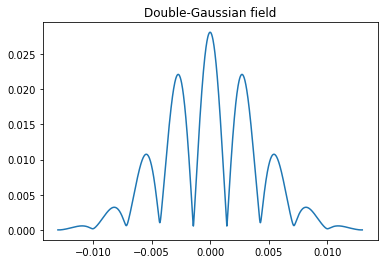

In [10]:
plt.plot(y,abs(E_dg(y,a,b)))
plt.title("Double-Gaussian field")

## Define a single function to explore the FFT:

In [11]:
def plotFFT(d,a,b):
    """Single function version of generating the FFT output"""
    TotalField = E_dg(y,a,b)+E_lo(y,d)
    TotalIntensity=TotalField*TotalField.conj()
    plt.plot(abs(fft(TotalIntensity)),".-")
    plt.ylim([0,10])
    plt.xlim([0,650])
    plt.title("FFT output")

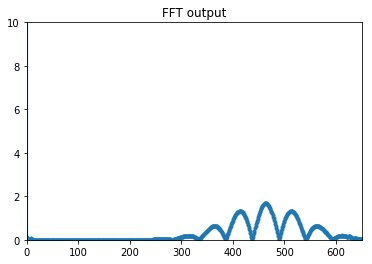

In [12]:
plotFFT(d=0.046,a=0.5e-3,b=0.08e-3)

This agrees well with Matt's code using symbolic calculations. The main difference I see is in the size of the low-frequency peak. It's much smaller here than in his version.

## d=0.035

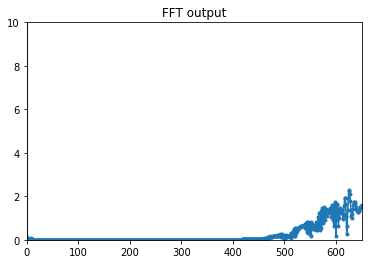

In [13]:
plotFFT(d=0.035,a=0.5e-3,b=0.08e-3)

## d=0.02

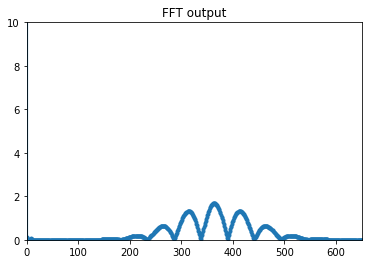

In [14]:
plotFFT(d=0.02,a=0.5e-3,b=0.08e-3)

## Double slit is still very different:

In [15]:
def plotFFTds(d,a,b):
    """Single function version of generating the FFT output"""
    TotalField = E_ds(y,a,b)+E_lo(y,d)
    TotalIntensity=TotalField*TotalField.conj()
    plt.plot(abs(fft(TotalIntensity)),".-")
    plt.ylim([0,0.1])
    plt.xlim([400,500])
    plt.title("FFT output")

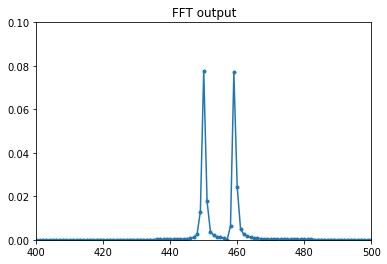

In [16]:
plotFFTds(d=0.025,a=0.5e-3,b=0.08e-3)

This does not agree with experimental results.

### TODO: replace with Gaussian LO: import gaussian beam function, and repeat:

In [17]:
E_lo_gauss = bopt.gaussian_beam(0,y,L,E0=1,wavelambda=795e-9,w0=0.02,k=[0,k*d/L,k])

#TODO: check these beam parameters for sanity

#TODO: k value make sense?

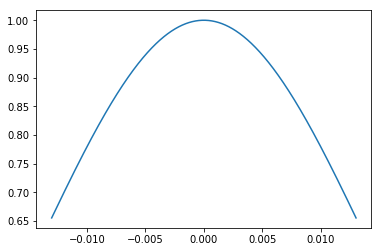

In [18]:
plt.plot(y,abs(E_lo_gauss))

In [19]:
TotalIntensity=(E_ds(y,a,b)+E_lo_gauss) * (E_ds(y,a,b)+E_lo_gauss).conj()

/Users/dawe7269/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


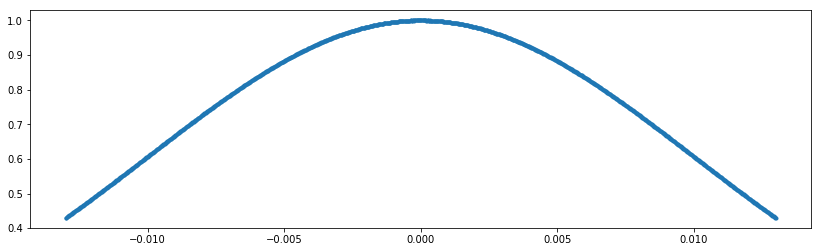

In [20]:
plt.figure(figsize=(14,4))
plt.plot(y,TotalIntensity,".-")

#plt.xlim([-.002,0])

(250, 350)

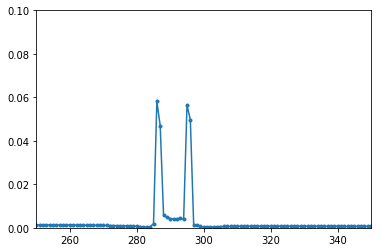

In [21]:
plt.plot(abs(fft(TotalIntensity)),".-")

plt.ylim([0,0.1]) # Had to lower the LO power quite a bit, and then zoom way in.

plt.xlim([250,350])

## Conclusions:
Double slit still gives two peaks, gaussian gives better agreement with data

## Zernike Local Oscillator: 

In [160]:
Z_1=1

In [161]:
def Z_2(x):
    return 2*x
def Z_3(y):
    return 2*y

In [162]:
def Z_4(x,y):
    return (6**.5)*2*x*y

In [163]:
def Z_5(x,y):
    return (3**.5)*(2*x**2+2*y**2-1) 
def Z_6(x,y):
    return (6**.5)*(x**2 - y**2)

In [164]:
def Z_7(x,y):
    return (8**.5)*(3*x**2*y-y**3)
def Z_8(x,y):
    return (8**.5)*(3*x**2*y-y+3*y**3-2*y)

In [165]:
def Z_9(x,y):
    return (8**.5)*(3*x**3+3*x*y**2-2*x)
def Z_10(x,y):
    return (8**.5)*(x**3-3*x*y**2)

In [166]:
def Psi(x,y,w,Cn=[.12,.08,.018,0.039,-.275,.031,.00,.00,0.003,-.027]):
    Zsum = Cn[0]*Z_1 + Cn[1]*Z_2(x) + Cn[2]*Z_3(y) + Cn[3]*Z_4(x,y) + Cn[4]*Z_5(x,y) 
    Zsum += Cn[5]*Z_6(x,y) + Cn[6]*Z_7(x,y) + Cn[7]*Z_8(x,y) + Cn[8]*Z_9(x,y) + Cn[9]*Z_10(x,y)
    return exp(-(x**2 + y**2)/ w**2)* exp(1j*2*pi*Zsum)

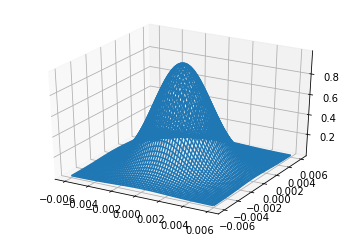

In [167]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x=linspace(-.006,.006,600)
y=linspace(-.006,.006,600)
X, Y = meshgrid(x,y)
Z=Psi(X,Y,w=.003,Cn=[.158,-.025,.025,-.007,-.143,-.008,-.006,.007,.01,-.011])
ax.plot_wireframe(X, Y, abs(Z), rstride=10, cstride=10)

In [168]:
LObeam = Z[:,300]

In [169]:
import BeamOptics as bopt

In [170]:
d=.027

y = linspace(-.006,.006,1200)

In [171]:
LObeam = bopt.gaussian_beam(0,y,L,E0=0.005,wavelambda=795e-9,w0=0.003,k=[0,k*d/L,k])


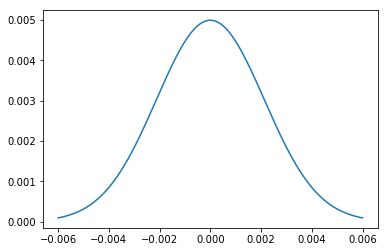

In [172]:
plt.plot(y,abs(LObeam))

In [173]:
TotalIntensity=(E(y)+LObeam) * (E(y)+LObeam).conj()

/home/photon/miniconda3/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


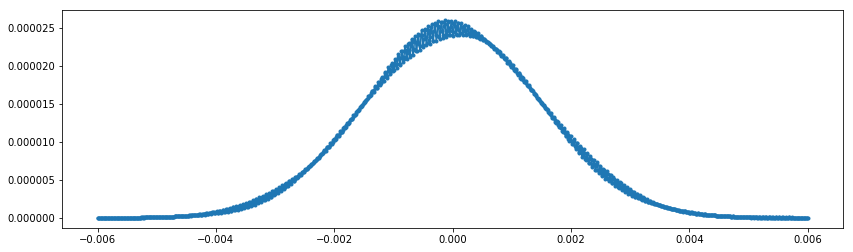

In [174]:
plt.figure(figsize=(14,4))
plt.plot(y,TotalIntensity,".-")

#plt.xlim([-.002,0])

(150, 250)

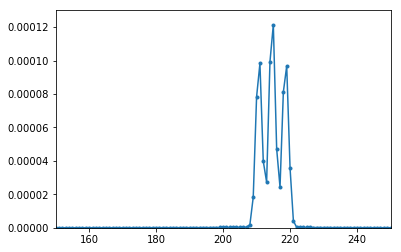

In [175]:
plt.plot(abs(fft(TotalIntensity)),".-")

plt.ylim([0,.00013]) # Had to lower the LO power quite a bit, and then zoom way in.

plt.xlim([150,250])